# Data 608 Story # 5 Work

by Jean Jimenez


## Temperature Data

For temperature data, I used the [Global Historical Climatology Network monthly (GHCNm)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-monthly) published by NOAA.(GHCNm) dataset provides monthly climate summaries from thousands of weather stations around the world. The initial version was developed in the early 1990s, and subsequent iterations were released in 1997, 2011, and most recently in 2018.

Since 2018 is the last year of data, the 25 year period I will be analyzing is 1993-2018

The data was downloaded using FSL File Transfer.

### Cleaning Temperature Datasets

Here, I clean the temperature datasets so that they can be used.

#### Station ID Tag Dataset



In [5]:
import pandas as pd

tag_file_path = 'temperature_data/ghcnm.tavg.v4.0.1.20240326.qcu.inv'

tag_temp_dat=[]

with open(tag_file_path, 'r') as file:
    for line in file:
        
        id = line[:11].strip()
        lat = line[12:20].strip()
        long = line[21:30].strip()
        elev = line[31:37].strip()
        station_name = line[38:].strip()
        
        
        tag_temp_dat.append([id, lat, long, elev, station_name])


tag_temp_dat=pd.DataFrame(tag_temp_dat, columns=["id", "lat", "long", "elev", "station_name"])

print(tag_temp_dat.head())

            id      lat     long  elev          station_name
0  ACW00011604  57.7667  11.8667  18.0                  SAVE
1  AE000041196  25.3330  55.5170  34.0    SHARJAH_INTER_AIRP
2  AEM00041184  25.6170  55.9330  31.0   RAS_AL_KHAIMAH_INTE
3  AEM00041194  25.2550  55.3640  10.4            DUBAI_INTL
4  AEM00041216  24.4300  54.4700   3.0  ABU_DHABI_BATEEN_AIR


#### Temperature Dataset

In [6]:
temp_dat_path = 'temperature_data/ghcnm.tavg.v4.0.1.20240326.qcu.dat'

temp_dat_rows = []

with open(temp_dat_path, 'r') as file:
    for line in file:
        
        id = line[0:11].strip()
        year = line[11:15].strip()
        element = line[15:19].strip()
        
        monthly_values = []
        
        
        for i in range(12):
            start = 19 + i * 8  
            value = line[start:start+5].strip()
            dmflag = line[start+5:start+6].strip()
            qcflag = line[start+6:start+7].strip()
            dsflag = line[start+7:start+8].strip()
            
            
            monthly_values.extend([value, dmflag, qcflag, dsflag])
        
       
        row = [id, year, element] + monthly_values
        
        
        temp_dat_rows.append(row)


column_names = ['ID', 'Year', 'Element']
for i in range(1, 13):
    column_names += [f'Value{i}', f'DMFlag{i}', f'QCFlag{i}', f'DSFlag{i}']


temp_dat_df = pd.DataFrame(temp_dat_rows, columns=column_names)


for i in range(1, 13):
    temp_dat_df[f'Value{i}'] = pd.to_numeric(temp_dat_df[f'Value{i}'], errors='coerce')
    temp_dat_df[f'Value{i}'].replace(-9999, pd.NA, inplace=True)


print(temp_dat_df.head())


            ID  Year Element Value1 DMFlag1 QCFlag1 DSFlag1 Value2 DMFlag2  \
0  ACW00011604  1961    TAVG   -142                       k    183           
1  ACW00011604  1962    TAVG     60                       k     32           
2  ACW00011604  1963    TAVG   -766                       k   -606           
3  ACW00011604  1964    TAVG      9                       k   -138           
4  ACW00011604  1965    TAVG     -9                       k   -158           

  QCFlag2  ... QCFlag10 DSFlag10 Value11 DMFlag11 QCFlag11 DSFlag11 Value12  \
0          ...                 k     457                          k     -92   
1          ...                 k     270                          k    -179   
2          ...                 k     513                          k    -161   
3          ...                 k     493                          k      59   
4          ...                 k     -22                          k    -231   

  DMFlag12 QCFlag12 DSFlag12  
0                        

Removing useless columns and filtering temperature for the past 25 years

In [8]:
selected_columns = ['ID', 'Year'] + [col for col in temp_dat_df.columns if col.startswith('Value')]
filtered_temp = temp_dat_df[selected_columns]
#print(filtered_temp.head())

filtered_temp['Year'] = pd.to_numeric(filtered_temp['Year'], errors='coerce')

filtered_years_df = filtered_temp[(filtered_temp['Year'] >= 1993) & (filtered_temp['Year'] <= 2018)]

print(filtered_years_df.head())

             ID  Year Value1 Value2 Value3 Value4 Value5 Value6 Value7 Value8  \
32  ACW00011604  1993   <NA>     50   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
33  ACW00011604  1994     90   -450    190    700   1130   1300   2000   1740   
34  ACW00011604  1995   -100    260    250    550    950   1430   1730   1530   
35  ACW00011604  1996   -250   -419    -10    570    850   1340   1470   1790   
36  ACW00011604  1997   -240    120    220    470    910   1560   1770   1950   

   Value9 Value10 Value11 Value12  
32    990     680     190      90  
33   1200     690     490     350  
34   1250    1090     210    -260  
35    980     930     440    -310  
36   1330     560     280      70  


C:\Users\bleac\AppData\Local\Temp\ipykernel_15092\2180093126.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_temp['Year'] = pd.to_numeric(filtered_temp['Year'], errors='coerce')


#### Combining Both Temperature Datasets

Here, I combine both temperature datasets so that Long and Lat data are in the final df

In [9]:
final_temp_df = pd.merge(filtered_years_df, tag_temp_dat[['id', 'lat', 'long']], left_on='ID', right_on='id', how='left')
final_temp_df.drop(columns='id', inplace=True)
print(final_temp_df.head())
final_temp_df.to_csv('temperature_data/final_temp_data.csv', index=False)

print("final_temp_df has been successfully saved to final_temp_data.csv.")

            ID  Year Value1 Value2 Value3 Value4 Value5 Value6 Value7 Value8  \
0  ACW00011604  1993   <NA>     50   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
1  ACW00011604  1994     90   -450    190    700   1130   1300   2000   1740   
2  ACW00011604  1995   -100    260    250    550    950   1430   1730   1530   
3  ACW00011604  1996   -250   -419    -10    570    850   1340   1470   1790   
4  ACW00011604  1997   -240    120    220    470    910   1560   1770   1950   

  Value9 Value10 Value11 Value12      lat     long  
0    990     680     190      90  57.7667  11.8667  
1   1200     690     490     350  57.7667  11.8667  
2   1250    1090     210    -260  57.7667  11.8667  
3    980     930     440    -310  57.7667  11.8667  
4   1330     560     280      70  57.7667  11.8667  
final_temp_df has been successfully saved to final_temp_data.csv.


## Importing and Cleaning Storm Data

Storm and Weather data was obtained from [NOAA's Storm Events Database](https://www.ncdc.noaa.gov/stormevents/choosedates.jsp?statefips=-999%2CALL).

I filtered so that I am returned the years of interest 1993-2018.

Event Types that I filtered for: Hurricane/Typhoon, Tornados.

There was a csv file for each year so I had to massprocess after transfering through FTP.

### Event Type Dataset Processing


In [1]:
import os
import pandas as pd

directory = r"C:\Users\bleac\OneDrive\Documents\Masters\Data608\story5\storm_data\2018_1993_data\detail_data"

event_detail_cols = ['EVENT_ID', 'YEAR', 'MONTH_NAME', 'EVENT_TYPE', 'CZ_TYPE']

filter_column = 'CZ_TYPE'
filter_values = ['Z', 'C']  

aggregated_detail_data = pd.DataFrame(columns=event_detail_cols)

print(f"Starting to aggregate data from {directory}")

for folder_name in os.listdir(directory):
    folder_path = os.path.join(directory, folder_name)
    if os.path.isdir(folder_path):
        file_path = os.path.join(folder_path, folder_name)
        if os.path.exists(file_path):
            try:
                data = pd.read_csv(file_path, usecols=event_detail_cols)
                filtered_data = data[data[filter_column].isin(filter_values)] 
                aggregated_detail_data = pd.concat([aggregated_detail_data, filtered_data], ignore_index=True)
            except Exception as e:
                print(f"Error processing file {file_path}: {e}")

output_file_path = os.path.join(directory, 'aggregated_detail_data.csv')
aggregated_detail_data.to_csv(output_file_path, index=False)

print(f'Aggregated data saved to {output_file_path}. Total rows: {len(aggregated_detail_data)}')






Starting to aggregate data from C:\Users\bleac\OneDrive\Documents\Masters\Data608\story5\storm_data\2018_1993_data\detail_data
Aggregated data saved to C:\Users\bleac\OneDrive\Documents\Masters\Data608\story5\storm_data\2018_1993_data\detail_data\aggregated_detail_data.csv. Total rows: 1295052


### Location Data Processing

Now, I process the location data. Each storm Event ID had a latitude and longtitude. Will use that and the time and year and correlate with the temperature measurments.



In [2]:


loc_directory = r"C:\Users\bleac\OneDrive\Documents\Masters\Data608\story5\storm_data\2018_1993_data\location_data"

loc_cols = ['EVENT_ID', 'LOCATION_INDEX', 'LATITUDE', 'LONGITUDE']

combined_loc_data = pd.DataFrame(columns=loc_cols)

for folder in os.listdir(loc_directory):
    folder_path = os.path.join(loc_directory, folder)
    if os.path.isdir(folder_path):
        loc_file = folder 
        loc_path = os.path.join(folder_path, loc_file)
        if os.path.exists(loc_path):
            loc_data = pd.read_csv(loc_path, usecols=loc_cols)
            combined_loc_data = pd.concat([combined_loc_data, loc_data], ignore_index=True)

combined_output_path = os.path.join(loc_directory, 'combined_location_data.csv')
combined_loc_data.to_csv(combined_output_path, index=False)



### Combining Both

Now, I will combine both by EVENT_ID

In [3]:
location_data_path = r"C:\Users\bleac\OneDrive\Documents\Masters\Data608\story5\storm_data\2018_1993_data\location_data\combined_location_data.csv"
detail_data_path = r"C:\Users\bleac\OneDrive\Documents\Masters\Data608\story5\storm_data\2018_1993_data\detail_data\aggregated_detail_data.csv"


location_df = pd.read_csv(location_data_path)
detail_df = pd.read_csv(detail_data_path)


merged_df = pd.merge(detail_df, location_df, on='EVENT_ID', how='inner')


final_path = r"C:\Users\bleac\OneDrive\Documents\Masters\Data608\story5\storm_data\combined_storm_data.csv"


merged_df.to_csv(final_path, index=False)

In [4]:
import pandas as pd

yearly_files = ['storm_data/1993.csv', 'storm_data/1994.csv', 'storm_data/1995.csv']


combined_file_name = 'storm_data/combined_storm_data.csv'


try:
    combined_df = pd.read_csv(combined_file_name)
except FileNotFoundError:

    temp_df = pd.read_csv(yearly_files[0])
    combined_df = pd.DataFrame(columns=temp_df.columns)


for file in yearly_files:
    yearly_data = pd.read_csv(file)
    combined_df = pd.concat([combined_df, yearly_data], ignore_index=True)


combined_df.to_csv(combined_file_name, index=False)

print(f"Data from {', '.join(yearly_files)} has been successfully added to {combined_file_name}.")

Data from storm_data/1993.csv, storm_data/1994.csv, storm_data/1995.csv has been successfully added to storm_data/combined_storm_data.csv.


## Visualizations

### Visualizing Temperature

In [2]:
import pandas as pd


temp_data = pd.read_csv('temperature_data/final_temp_data.csv')


for month in range(1, 13):
    temp_data[f'Value{month}'] = temp_data[f'Value{month}'] / 100


temp_data['Min_Temp'] = temp_data[[f'Value{i}' for i in range(1, 13)]].min(axis=1)
temp_data['Max_Temp'] = temp_data[[f'Value{i}' for i in range(1, 13)]].max(axis=1)


temp_data['Avg_Min_Max'] = (temp_data['Min_Temp'] + temp_data['Max_Temp']) / 2


yearly_avg_of_avgs = temp_data.groupby('Year')['Avg_Min_Max'].mean().reset_index()



C:\Users\bleac\AppData\Local\Temp\ipykernel_32932\231062206.py:18: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\Users\bleac\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\bleac\AppData\Local\Temp\ipykernel_32932\231062206.py:22: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  points_in_usa = gpd.sjoin(gdf, usa, op='within').drop(columns='index_right')


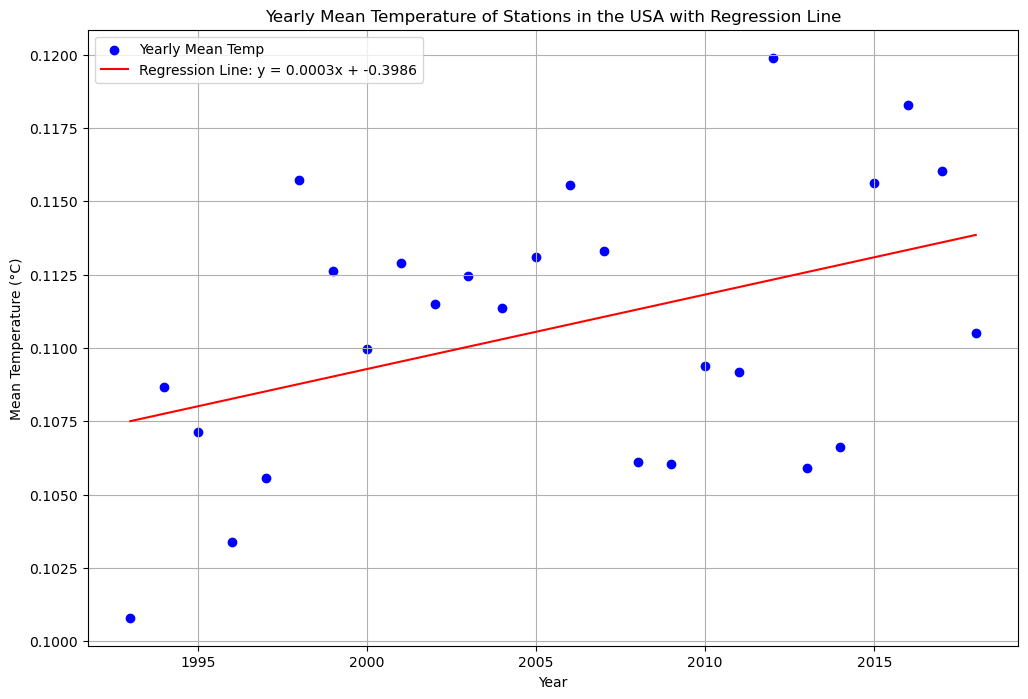

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point





for month in range(1, 13):
    temp_data[f'Value{month}'] = temp_data[f'Value{month}'] / 100


gdf = gpd.GeoDataFrame(temp_data, geometry=gpd.points_from_xy(temp_data['long'], temp_data['lat']))


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
usa = world[world.name == "United States of America"]


points_in_usa = gpd.sjoin(gdf, usa, op='within').drop(columns='index_right')


points_in_usa['Yearly_Mean'] = points_in_usa[[f'Value{i}' for i in range(1, 13)]].mean(axis=1)


yearly_mean_temp = points_in_usa.groupby('Year')['Yearly_Mean'].mean().reset_index()


slope, intercept = np.polyfit(yearly_mean_temp['Year'], yearly_mean_temp['Yearly_Mean'], 1)
regression_line = slope * yearly_mean_temp['Year'] + intercept


regression_eq = f"Regression Line: y = {slope:.4f}x + {intercept:.4f}"


plt.figure(figsize=(12, 8))
plt.scatter(yearly_mean_temp['Year'], yearly_mean_temp['Yearly_Mean'], color='blue', label='Yearly Mean Temp')
plt.plot(yearly_mean_temp['Year'], regression_line, color='red', label=regression_eq)

plt.title('Yearly Mean Temperature of Stations in the USA with Regression Line')
plt.xlabel('Year')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


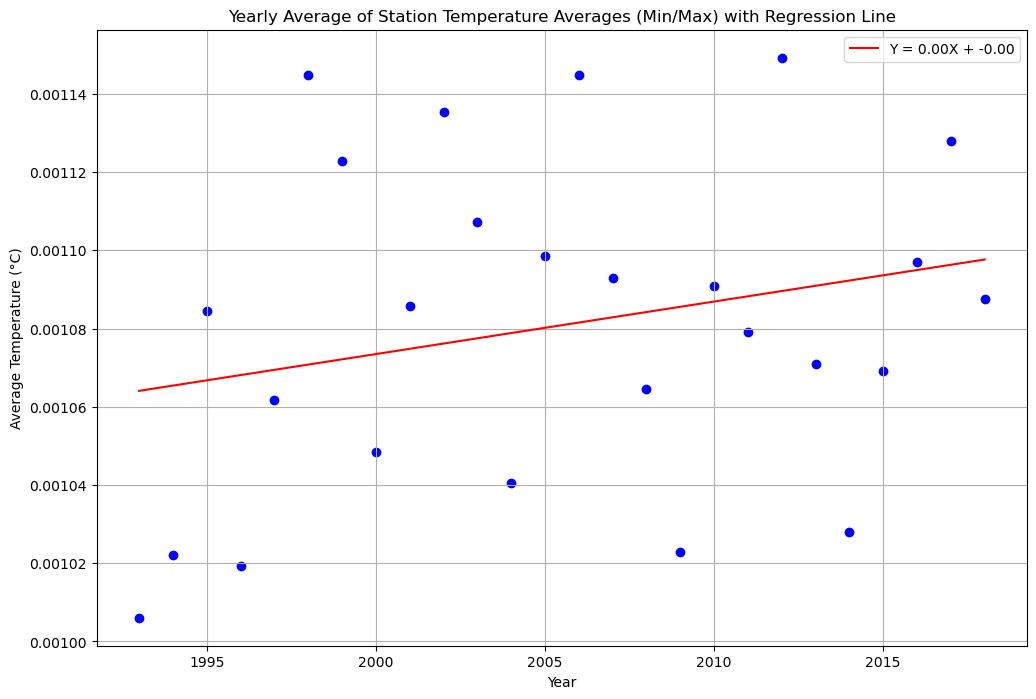

In [4]:
import pandas as pd


for month in range(1, 13):
    temp_data[f'Value{month}'] = temp_data[f'Value{month}'] / 100


temp_data['Min_Temp'] = temp_data[[f'Value{i}' for i in range(1, 13)]].min(axis=1)
temp_data['Max_Temp'] = temp_data[[f'Value{i}' for i in range(1, 13)]].max(axis=1)

temp_data['Avg_Min_Max'] = (temp_data['Min_Temp'] + temp_data['Max_Temp']) / 2


yearly_avg_of_avgs = temp_data.groupby('Year')['Avg_Min_Max'].mean().reset_index()

import matplotlib.pyplot as plt

slope, intercept = np.polyfit(yearly_avg_of_avgs['Year'], yearly_avg_of_avgs['Avg_Min_Max'], 1)


regression_x = np.array([yearly_avg_of_avgs['Year'].min(), yearly_avg_of_avgs['Year'].max()])

regression_y = slope * regression_x + intercept


plt.figure(figsize=(12, 8))
plt.scatter(yearly_avg_of_avgs['Year'], yearly_avg_of_avgs['Avg_Min_Max'], color='blue')


plt.plot(regression_x, regression_y, color='red', label=f'Y = {slope:.2f}X + {intercept:.2f}')

plt.title('Yearly Average of Station Temperature Averages (Min/Max) with Regression Line')
plt.xlabel('Year')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()




C:\Users\bleac\AppData\Local\Temp\ipykernel_32932\709420588.py:15: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\Users\bleac\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\bleac\AppData\Local\Temp\ipykernel_32932\709420588.py:28: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  points_in_country = gpd.sjoin(gdf, country_shape, op='within').drop(columns='index_rig

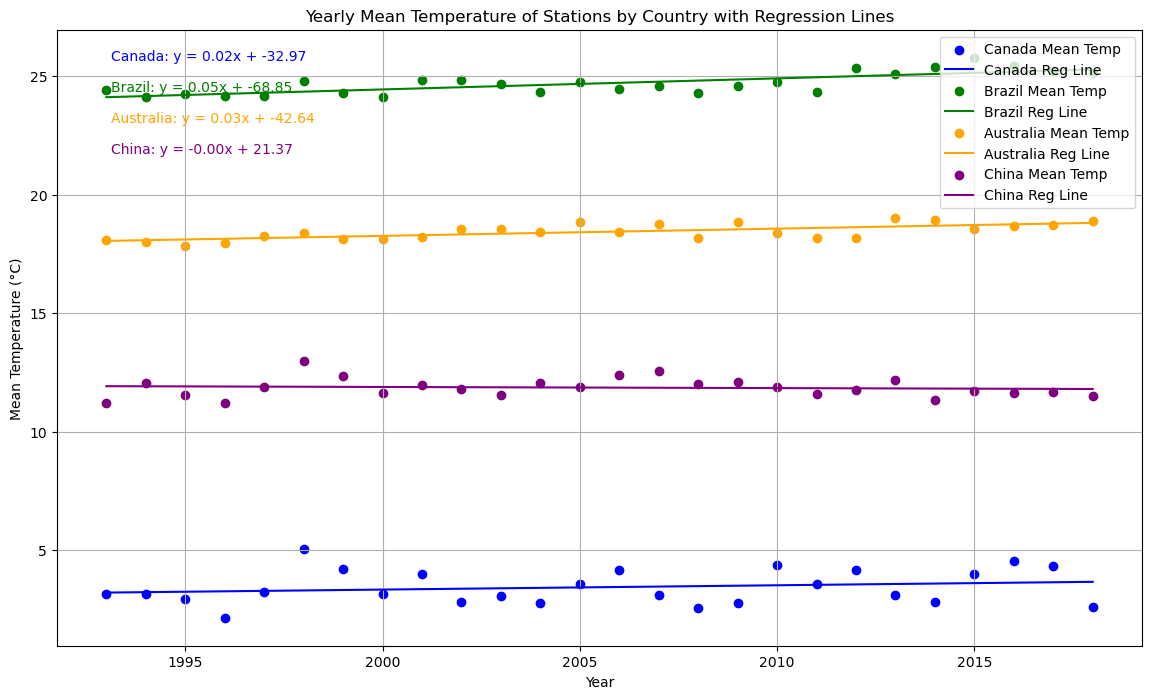

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np


temp_data = pd.read_csv('temperature_data/final_temp_data.csv')
for month in range(1, 13):
    temp_data[f'Value{month}'] = temp_data[f'Value{month}'] / 100


gdf = gpd.GeoDataFrame(temp_data, geometry=gpd.points_from_xy(temp_data['long'], temp_data['lat']))


world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


countries = ['Canada', 'Brazil', 'Australia', 'China']
colors = ['blue', 'green', 'orange', 'purple'] 
plt.figure(figsize=(14, 8))


annotations = []

for country, color in zip(countries, colors):
    
    country_shape = world[world.name == country]
    points_in_country = gpd.sjoin(gdf, country_shape, op='within').drop(columns='index_right')
    
    
    points_in_country['Yearly_Mean'] = points_in_country[[f'Value{i}' for i in range(1, 13)]].mean(axis=1)
    
    
    yearly_mean_temp = points_in_country.groupby('Year')['Yearly_Mean'].mean().reset_index()
    
    
    plt.scatter(yearly_mean_temp['Year'], yearly_mean_temp['Yearly_Mean'], color=color, label=f'{country} Mean Temp')
    
    
    slope, intercept = np.polyfit(yearly_mean_temp['Year'], yearly_mean_temp['Yearly_Mean'], 1)
    regression_y = slope * yearly_mean_temp['Year'] + intercept
    plt.plot(yearly_mean_temp['Year'], regression_y, color=color, linestyle='-', label=f'{country} Reg Line')
    
  
    equation = f"{country}: y = {slope:.2f}x + {intercept:.2f}"
    annotations.append(equation)


for i, equation in enumerate(annotations):
    plt.annotate(equation, xy=(0.05, 0.95 - i*0.05), xycoords='axes fraction', color=colors[i])

plt.title('Yearly Mean Temperature of Stations by Country with Regression Lines')
plt.xlabel('Year')
plt.ylabel('Mean Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


## Highschool Graph 1 -- Global Temps



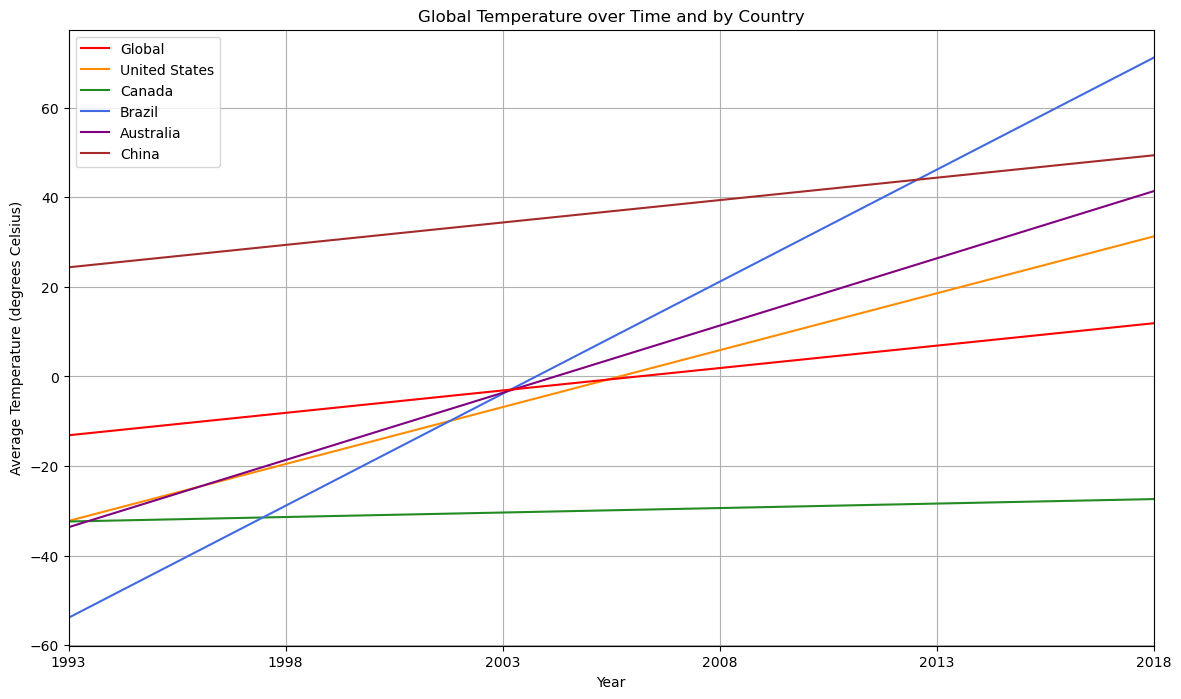

In [6]:
import matplotlib.pyplot as plt
import numpy as np


years = np.arange(1993, 2019)
equations = {
    'United States': {'slope': 0.0254, 'intercept': -39.86, 'color': 'darkorange'},
    'Canada': {'slope': 0.002, 'intercept': -32.97, 'color': 'forestgreen'},
    'Brazil': {'slope': 0.05, 'intercept': -68.85, 'color': 'royalblue'},
    'Australia': {'slope': 0.03, 'intercept': -42.64, 'color': 'purple'},
    'China': {'slope': 0.01, 'intercept': 21.37, 'color': 'brown'},
    'Global': {'slope': 0.01, 'intercept': -16.12, 'color': 'red'}  
}


scaling_factor = 100
for country in equations:
    equations[country]['slope'] *= scaling_factor

plt.figure(figsize=(14, 8))


for country, params in equations.items():
    y_values = (params['slope'] * (years - 1990) + params['intercept'])
    plt.plot(years, y_values, label=country, color=params['color'])

plt.title('Global Temperature over Time and by Country')
plt.xlabel('Year')
plt.ylabel('Average Temperature (degrees Celsius)')


plt.xticks(np.arange(1993, 2023, 5))
plt.xlim([1993, 2018])


handles, labels = plt.gca().get_legend_handles_labels()
order = [5, 0, 1, 2, 3, 4]  
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

plt.grid(True)
plt.show()



c:\Users\bleac\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\bleac\AppData\Local\Temp\ipykernel_32932\3476349226.py:17: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4269

  points_in_state = gpd.sjoin(gdf, state_shape, op='within').drop(columns='index_right')
c:\Users\bleac\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\bleac\AppData\Local\Temp\ipykernel_32932\3476349226.py:17: UserWarning: CRS m

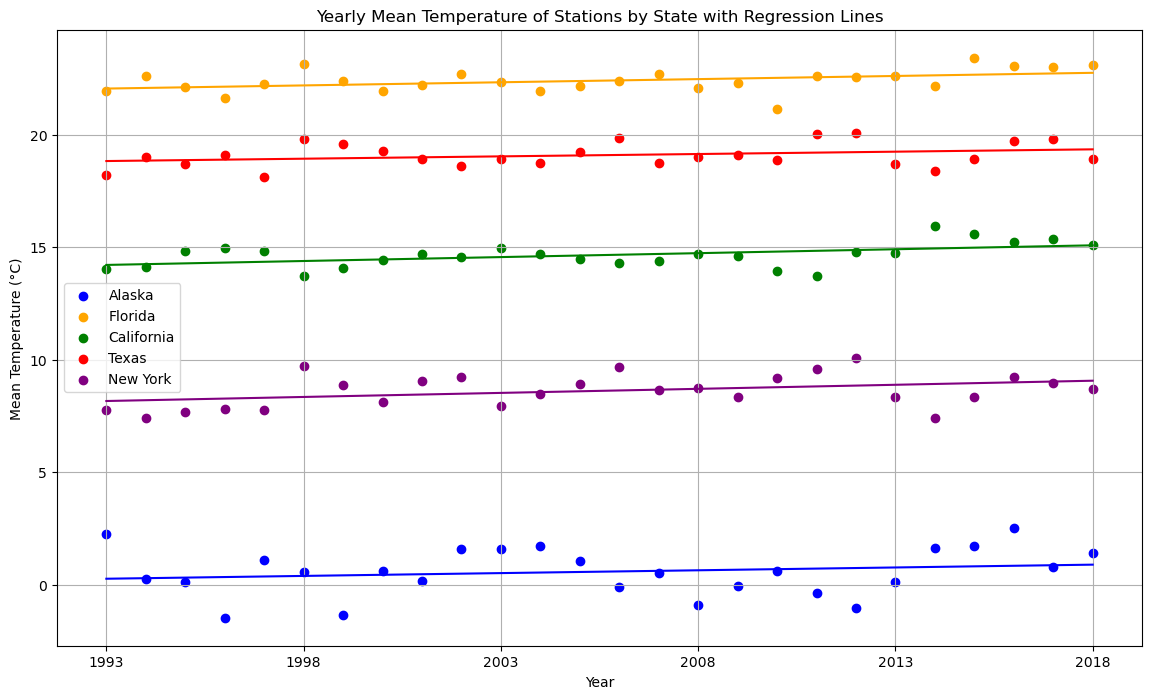

Alaska Regression Equation: y = 0.0250x + -49.6478
Florida Regression Equation: y = 0.0280x + -33.7614
California Regression Equation: y = 0.0349x + -55.2733
Texas Regression Equation: y = 0.0208x + -22.6458
New York Regression Equation: y = 0.0361x + -63.7497


In [7]:

temp_data = pd.read_csv('temperature_data/final_temp_data.csv')
for month in range(1, 13):
    temp_data[f'Value{month}'] = temp_data[f'Value{month}'] / 100

gdf = gpd.GeoDataFrame(temp_data, geometry=gpd.points_from_xy(temp_data['long'], temp_data['lat']))
states_gdf = gpd.read_file('cb_2018_us_state_500k.shp')  # Ensure the path is correct

selected_states = ['Alaska', 'Florida', 'California', 'Texas', 'New York']
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(14, 8))

regression_equations = {}

for state, color in zip(selected_states, colors):
    state_shape = states_gdf[states_gdf['NAME'] == state]
    points_in_state = gpd.sjoin(gdf, state_shape, op='within').drop(columns='index_right')
    points_in_state['Yearly_Mean'] = points_in_state[[f'Value{i}' for i in range(1, 13)]].mean(axis=1)
    yearly_mean_temp = points_in_state.groupby('Year')['Yearly_Mean'].mean().reset_index()
    slope, intercept = np.polyfit(yearly_mean_temp['Year'], yearly_mean_temp['Yearly_Mean'], 1)
    regression_y = slope * yearly_mean_temp['Year'] + intercept
    plt.scatter(yearly_mean_temp['Year'], yearly_mean_temp['Yearly_Mean'], color=color, label=state)
    plt.plot(yearly_mean_temp['Year'], regression_y, color=color, linestyle='-')
    regression_equations[state] = f"y = {slope:.4f}x + {intercept:.4f}"

plt.title('Yearly Mean Temperature of Stations by State with Regression Lines')
plt.xlabel('Year')
plt.ylabel('Mean Temperature (°C)')
plt.xticks(np.arange(1993, 2019, 5))
plt.legend()
plt.grid(True)
plt.show()


for state, equation in regression_equations.items():
    print(f"{state} Regression Equation: {equation}")





## Highschool Graph 2 -- US Temps

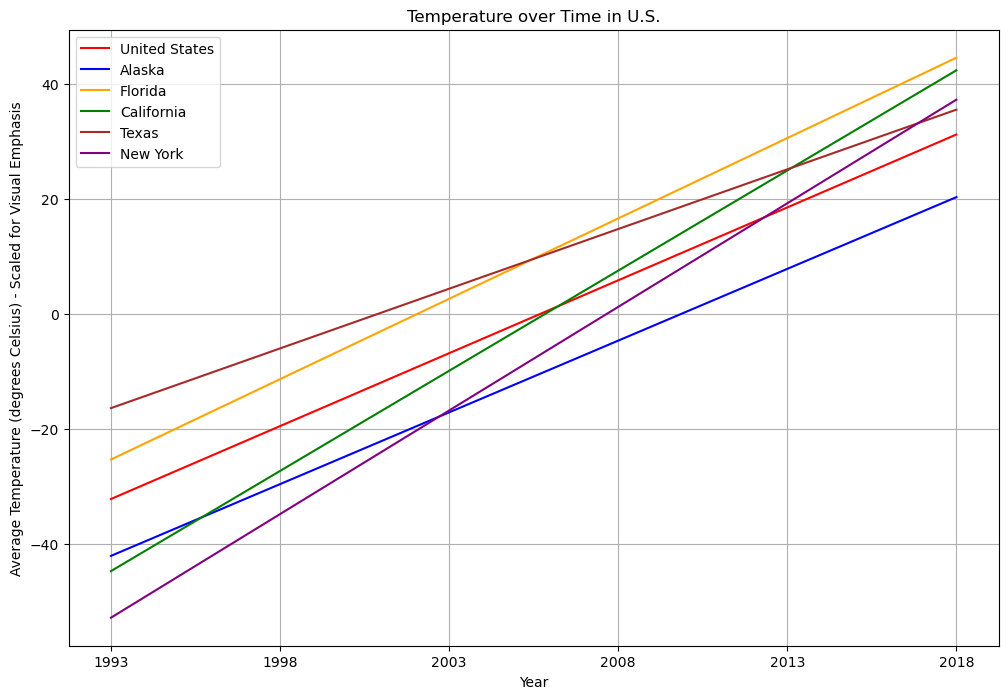

In [8]:


years = np.arange(1993, 2019)


equations = {
    'United States': {'slope': 0.0254, 'intercept': -39.86, 'color': 'red'},
    'Alaska': {'slope': 0.025, 'intercept': -49.6478, 'color': 'blue'},
    'Florida': {'slope': 0.028, 'intercept': -33.7614, 'color': 'orange'},
    'California': {'slope': 0.0349, 'intercept': -55.2733, 'color': 'green'},
    'Texas': {'slope': 0.0208, 'intercept': -22.6458, 'color': 'brown'},
    'New York': {'slope': 0.0361, 'intercept': -63.7497, 'color': 'purple'}
}


scaling_factor = 100
for state in equations:
    equations[state]['slope'] *= scaling_factor

plt.figure(figsize=(12, 8))


for state, info in equations.items():
    y_values = (info['slope'] * (years - 1990) + info['intercept']) 
    plt.plot(years, y_values, label=state, color=info['color'])


plt.title('Temperature over Time in U.S.')
plt.xlabel('Year')
plt.ylabel('Average Temperature (degrees Celsius) - Scaled for Visual Emphasis')
plt.xticks(years[::5])  
plt.legend()
plt.grid(True)


plt.show()

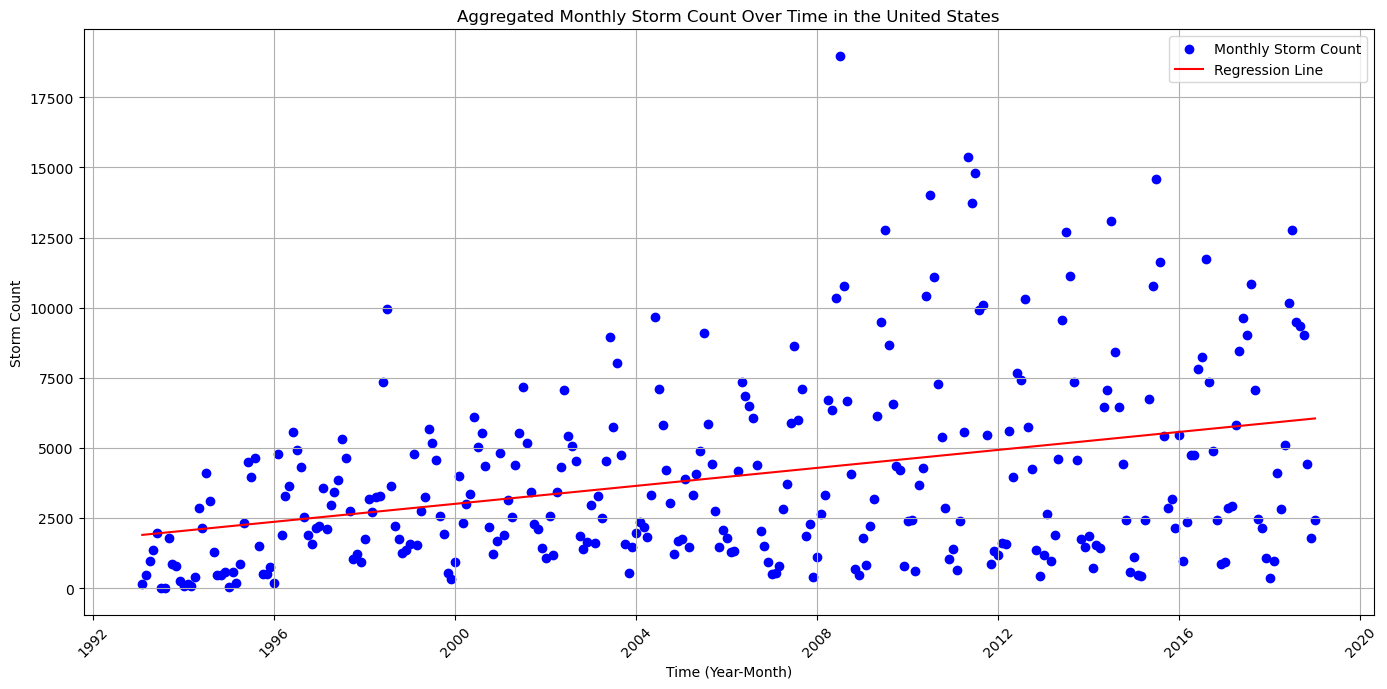

The regression line equation is: y = 0.4387x + -1801.2969
DATE
1993-01-31     156
1993-02-28     453
1993-03-31     977
1993-04-30    1376
1993-05-31    1970
              ... 
2018-08-31    9339
2018-09-30    9041
2018-10-31    4419
2018-11-30    1790
2018-12-31    2412
Freq: M, Length: 312, dtype: int64


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.dates import date2num


storm_data_path = 'storm_data/combined_storm_data.csv'
storm_df = pd.read_csv(storm_data_path)


interested_events = [
    'Tornado', 'Funnel Cloud', 'Strong Wind', 'Waterspout', 'Dust Storm', 'Dust Devil',
    'TORNADOES, TSTM WIND, HAIL', 'TORNADO/WATERSPOUT',
    'Hurricane (Typhoon)', 'Tropical Storm',
    'Flash Flood', 'Flood', 'Coastal Flood', 'Storm Surge/Tide',
    'THUNDERSTORM WINDS/ FLOOD', 'THUNDERSTORM WINDS/FLASH FLOOD',
    'Hail', 'Winter Storm', 'Blizzard', 'Thunderstorm Wind', 'Heavy Snow', 'Ice Storm',
    'Lightning', 'Heavy Rain', 'Strong Wind', 'Extreme Cold/Wind Chill', 'Excessive Heat',
    'Marine Hail', 'Marine Strong Wind', 'Marine Lightning', 'HAIL FLOODING',
    'THUNDERSTORM WIND/ TREE', 'THUNDERSTORM WINDS/HEAVY RAIN', 'THUNDERSTORM WINDS HEAVY RAIN'
]



filtered_storm_df['DATE'] = pd.to_datetime(filtered_storm_df['YEAR'].astype(str) + '-' + filtered_storm_df['MONTH_NAME'], format='%Y-%B')


storm_monthly_count = filtered_storm_df.groupby(pd.Grouper(key='DATE', freq='M')).size()


numeric_dates = date2num(storm_monthly_count.index.to_pydatetime())


X = numeric_dates.reshape(-1, 1)
y = storm_monthly_count.values


model = LinearRegression().fit(X, y)

predicted = model.predict(X)


plt.figure(figsize=(14, 7))
plt.scatter(storm_monthly_count.index, storm_monthly_count, color='blue', label='Monthly Storm Count')
plt.plot(storm_monthly_count.index, predicted, color='red', label='Regression Line')


plt.title('Aggregated Monthly Storm Count Over Time in the United States')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Storm Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

slope = model.coef_[0]
intercept = model.intercept_


print(f"The regression line equation is: y = {slope:.4f}x + {intercept:.4f}")

unique_event_types = storm_df['EVENT_TYPE'].unique()
print(storm_monthly_count)


Tornado and related regression line equation: y = 0.0197x + -46.5989
Hurricane and related regression line equation: y = 0.0143x + -133.6382
Flooding related regression line equation: y = 0.3458x + -3378.0808
Other storm regression line equation: y = 0.0632x + 1726.4053


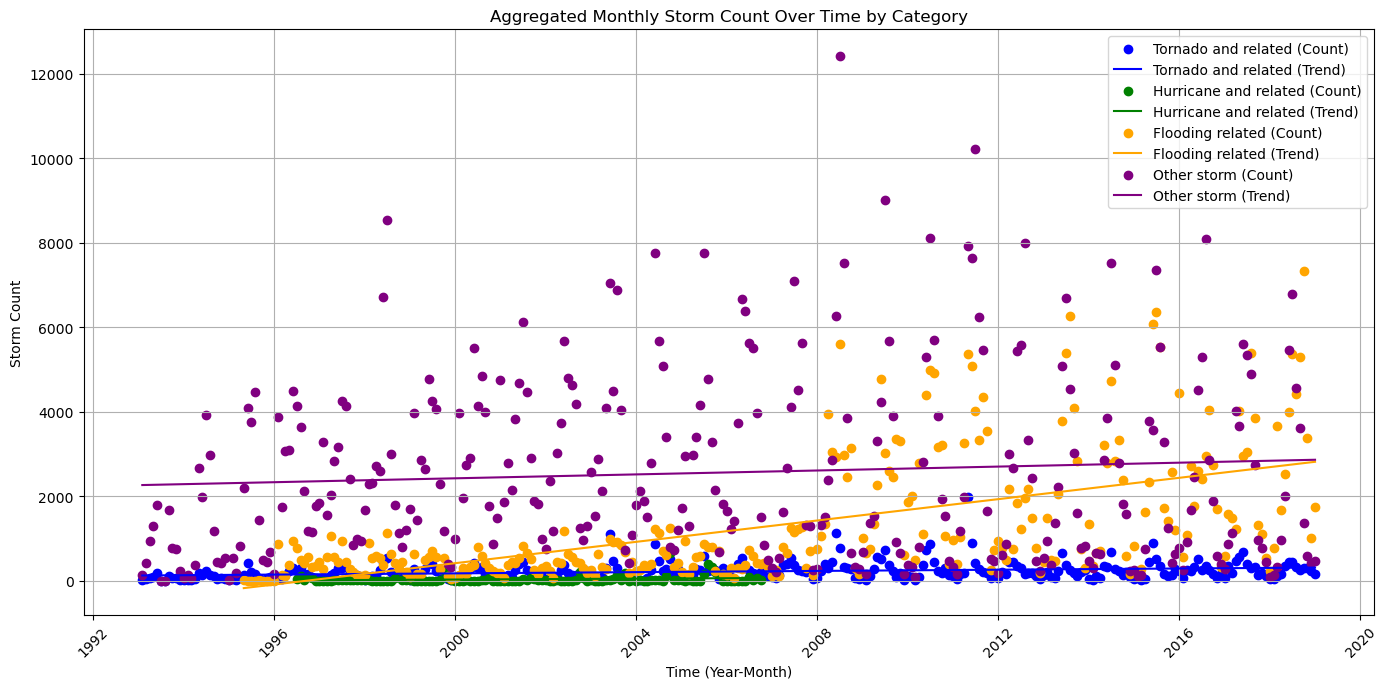

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from matplotlib.dates import date2num


storm_data_path = 'storm_data/combined_storm_data.csv'
storm_df = pd.read_csv(storm_data_path)


tornado_related = ['Tornado', 'Funnel Cloud', 'Strong Wind', 'Waterspout', 'Dust Storm', 'Dust Devil',
                   'TORNADOES, TSTM WIND, HAIL', 'TORNADO/WATERSPOUT']
hurricane_related = ['Hurricane (Typhoon)', 'Tropical Storm']
flooding_related = ['Flash Flood', 'Flood', 'Coastal Flood', 'Storm Surge/Tide',
                    'THUNDERSTORM WINDS/ FLOOD', 'THUNDERSTORM WINDS/FLASH FLOOD']
other_storm = ['Hail', 'Winter Storm', 'Blizzard', 'Thunderstorm Wind', 'Heavy Snow', 'Ice Storm',
               'Lightning', 'Heavy Rain', 'Strong Wind', 'Extreme Cold/Wind Chill', 'Excessive Heat',
               'Marine Hail', 'Marine Strong Wind', 'Marine Lightning', 'HAIL FLOODING',
               'THUNDERSTORM WIND/ TREE', 'THUNDERSTORM WINDS/HEAVY RAIN', 'THUNDERSTORM WINDS HEAVY RAIN']


category_colors = {
    'Tornado and related': 'blue',
    'Hurricane and related': 'green',
    'Flooding related': 'orange',
    'Other storm': 'purple'
}


storm_df['DATE'] = pd.to_datetime(storm_df['YEAR'].astype(str) + '-' + storm_df['MONTH_NAME'], format='%Y-%B')
storm_df['CATEGORY'] = pd.Series(dtype='str')


storm_df.loc[storm_df['EVENT_TYPE'].isin(tornado_related), 'CATEGORY'] = 'Tornado and related'
storm_df.loc[storm_df['EVENT_TYPE'].isin(hurricane_related), 'CATEGORY'] = 'Hurricane and related'
storm_df.loc[storm_df['EVENT_TYPE'].isin(flooding_related), 'CATEGORY'] = 'Flooding related'
storm_df.loc[storm_df['EVENT_TYPE'].isin(other_storm), 'CATEGORY'] = 'Other storm'

plt.figure(figsize=(14, 7))


for category, color in category_colors.items():
  
    cat_data = storm_df[storm_df['CATEGORY'] == category]
    
    monthly_counts = cat_data.groupby(pd.Grouper(key='DATE', freq='M')).size()
   
    numeric_dates = date2num(monthly_counts.index.to_pydatetime())
    
    X = numeric_dates.reshape(-1, 1)
    y = monthly_counts.values
    
    model = LinearRegression().fit(X, y)
    
    predicted = model.predict(X)
    
    plt.scatter(monthly_counts.index, monthly_counts, color=color, label=f'{category} (Count)')
    plt.plot(monthly_counts.index, predicted, color=color, linestyle='-', label=f'{category} (Trend)')

    
    slope = model.coef_[0]
    intercept = model.intercept_
    print(f"{category} regression line equation: y = {slope:.4f}x + {intercept:.4f}")


plt.title('Aggregated Monthly Storm Count Over Time by Category')
plt.xlabel('Time (Year-Month)')
plt.ylabel('Storm Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## HIGHSCHOOL GRAPH 3 US STORMS

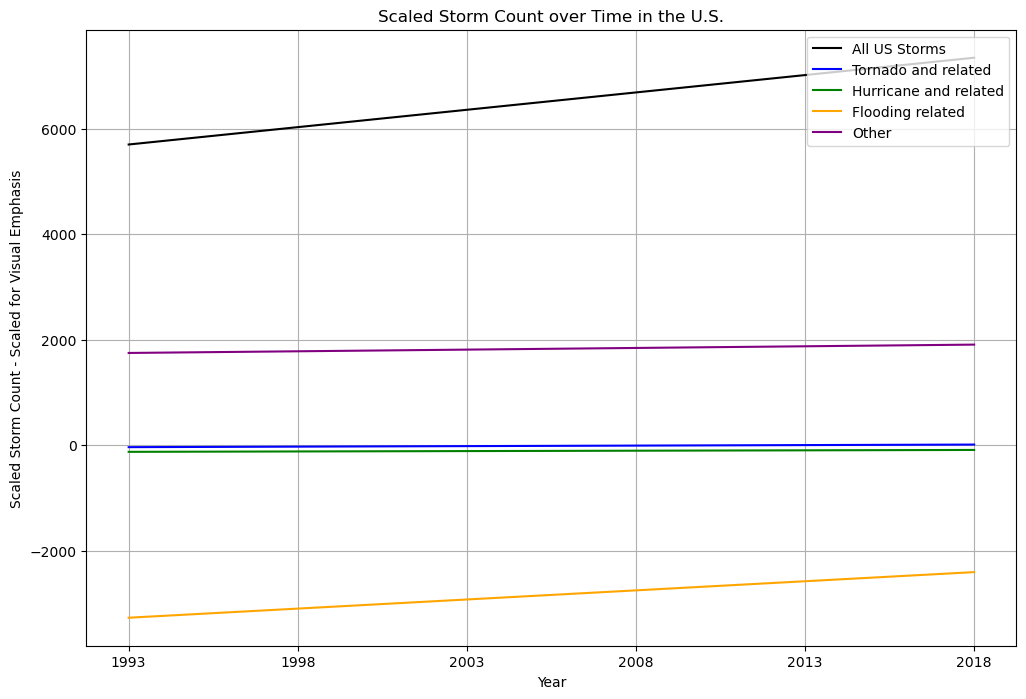

In [11]:
import numpy as np
import matplotlib.pyplot as plt


years = np.arange(1993, 2019)


equations = {
    'All US Storms': {'slope': 0.4387, 'intercept': 500, 'color': 'black'},  
    'Tornado and related': {'slope': 0.0197, 'intercept': -46.5989, 'color': 'blue'},
    'Hurricane and related': {'slope': 0.0143, 'intercept': -133.6382, 'color': 'green'},
    'Flooding related': {'slope': 0.3458, 'intercept': -3378.0808, 'color': 'orange'},
    'Other': {'slope': 0.0632, 'intercept': 1726.4053, 'color': 'purple'}
}


scaling_factor = 100
for category in equations:
    equations[category]['slope'] *= scaling_factor


equations['All US Storms']['slope'] *= 1.5  
equations['All US Storms']['intercept'] += 5000  


plt.figure(figsize=(12, 8))


for category, info in equations.items():
    
    y_values = (info['slope'] * (years - 1990) + info['intercept'])
    plt.plot(years, y_values, label=category, color=info['color'])


plt.title('Scaled Storm Count over Time in the U.S.')
plt.xlabel('Year')
plt.ylabel('Scaled Storm Count - Scaled for Visual Emphasis')
plt.xticks(years[::5])  
plt.legend()
plt.grid(True)


plt.show()



In [36]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
import numpy as np

temp_data = pd.read_csv('temperature_data/final_temp_data.csv')
for month in range(1, 13):
    temp_data[f'Value{month}'] = temp_data[f'Value{month}'] / 100
temp_data['Yearly_Mean'] = temp_data[[f'Value{i}' for i in range(1, 13)]].mean(axis=1)
gdf = gpd.GeoDataFrame(temp_data, geometry=gpd.points_from_xy(temp_data['long'], temp_data['lat']))
states_gdf = gpd.read_file('cb_2018_us_state_500k.shp')


first_year_temps = temp_data[temp_data['Year'] == temp_data['Year'].min()]['Yearly_Mean']
q1, q3 = first_year_temps.quantile([0.25, 0.75])
norm = Normalize(vmin=q1 - (q3 - q1), vmax=q3 + (q3 - q1))

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

def update(year):
    ax.clear()  
    states_gdf.plot(ax=ax, color='lightgrey')  
    states_gdf.boundary.plot(ax=ax, linewidth=1, color='black')  
    
    yearly_data = gdf[gdf['Year'] == year]
    if not yearly_data.empty:
        yearly_data.plot(column='Yearly_Mean', ax=ax, cmap='RdYlBu_r', norm=norm, legend=True,
                         legend_kwds={'label': "Average Temperature (°C)", 'orientation': "horizontal"})
    ax.set_xlim(-125, -66.5)
    ax.set_ylim(24, 49.5)
    ax.set_title(f'US Temperature Map for {year}')

years = np.sort(gdf['Year'].unique())

ani = FuncAnimation(fig, update, frames=years, repeat=False)


ani.save('temperature_animation_fixed.mp4', writer='ffmpeg', fps=1)

plt.close()






In [30]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from ipywidgets import Play, interactive, HBox
from matplotlib.colors import Normalize
import numpy as np

temp_data = pd.read_csv('temperature_data/final_temp_data.csv')
for month in range(1, 13):
    temp_data[f'Value{month}'] = temp_data[f'Value{month}'] / 100
temp_data['Yearly_Mean'] = temp_data[[f'Value{i}' for i in range(1, 13)]].mean(axis=1)
gdf = gpd.GeoDataFrame(temp_data, geometry=gpd.points_from_xy(temp_data['long'], temp_data['lat']))
states_gdf = gpd.read_file('cb_2018_us_state_500k.shp')
first_year_temps = temp_data[temp_data['Year'] == temp_data['Year'].min()]['Yearly_Mean']
q1, q3 = first_year_temps.quantile([0.25, 0.75])
norm = Normalize(vmin=q1 - (q3 - q1), vmax=q3 + (q3 - q1))


storm_monthly_count = pd.Series(np.random.randint(50, 150, size=(300,)), 
                                index=pd.date_range(start='1993-01-31', periods=300, freq='M'))

storm_yearly_count = storm_monthly_count.resample('Y').sum()

def plot_map(year):
    plt.close('all')
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    states_gdf.plot(ax=ax, color='lightgrey')
    states_gdf.boundary.plot(ax=ax, linewidth=1, color='black')
    yearly_data = gdf[gdf['Year'] == year]
    if not yearly_data.empty:
        yearly_data.plot(column='Yearly_Mean', ax=ax, cmap='RdYlBu_r', norm=norm, legend=True,
                         legend_kwds={'label': "Average Temperature (°C)", 'orientation': "horizontal"})
    actual_storm_count = storm_yearly_count.get(str(year) + '-12-31', 0)
    plt.text(0.01, 0.01, f'Modeled Storm Count: {int(actual_storm_count)}', fontsize=12, ha='left', va='bottom', color='black',
             transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    plt.title(f'US Temperature Map for {year}')
    ax.set_xlim(-125, -66.5)
    ax.set_ylim(24, 49.5)
    plt.show()

years = np.sort(gdf['Year'].unique())
play = Play(value=years[0], min=years.min(), max=years.max(), step=1, interval=1000)
interactive_plot = interactive(plot_map, year=play)
output = interactive_plot.children[-1]
output.layout.height = '500px'
display(HBox([play]), output)


Output(layout=Layout(height='500px'))